<a href="https://colab.research.google.com/github/abhishekmanglaa/YoutubeTrending/blob/master/Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
---
*Youtube, has become the world’s third most-visited website, after Google and Facebook. It’s a  popular, free (or ad-based) platform that allows the user to explore other users’ content. A video’s popularity and trending status is dependent on its ability to grab a viewers’ attention.  Therefore, we decided to analyze what characteristics makes these videos popular among viewers, and how the user’s interaction with the videos determine its popularity and trending ability.*  

A little about the data.
To perform this analysis we acquired a data set from Kaggle containing characteristics of Youtube trending videos, such as **number of comments, likes, dislikes, descriptions, trending date, publish time, category genre, number of views, video titles**, etc.  In particular we utilized the data given based on different countries, and decided to take a look at the trending videos in both the **U.S. and India**.  We developed a set of questions that will help us identify the trends and characteristics in trending videos.  We hope the conclusions we gather will help others create videos that trend on Youtube.

Link of the dataset is provided below.
https://www.kaggle.com/datasnaek/youtube-new. 




# Heavier grading on Data Analysis

---
Since we acquired our data from Kaggle, most of the data was already clean so we decided to focus mainly on Data Analysis rather than Data cleansing. 

In order to get our analysis as accurate as possible, we still needed to process and cleans our data. The work we did goes beyond basic data analysis and exploratory data analysis because we performed our analysis and grouped the data to gain insights specifically for each of our questions. 

# Data Processing

---
*This is not our main focus, but we'll do the cleaning part here*

*   Scraped video lengths (using Youtube V3 API) to determine if the length of a video has any significance on its trending status.

*   Standardized discrepancies in a video published and trending dates to perform our analysis better.

*   Merged category id to category name mapping so that we can clearly examine which particular category (genre) is trending in a particular region.

*   Created few new variables/columns such as trend_year, likes_percent, dislikes_percent to get better insights from the data.

*   Removed the thumbnail link column since it was of no use.

*   Cleaned the descriptions for each video by removing unnecessary information like url links. 


In [0]:
#Python Libraries 
import numpy as np
import pandas as pd
import datetime as dt
import re

#For the resource format (JSON)
import json
import folium

#Youtube Comments
import requests 

#Google API client methods
import os
import googleapiclient.discovery
from datetime import timedelta

#For scraping youtube URLs
from urllib.request import urlopen
from xml.dom.minidom import parseString

#ENV variable 1 for google API calls
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

#For the conversion of youtube time format (ISO 8601) to seconds
#import isodate

#Wordcloud
# !pip install wordcloud
# !pip install collections
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Importing the dataset from Gdrive
youtubeDF = pd.read_csv('/content/drive/Shared drives/Python Project/youtube-new/USvideos.csv')

#Let's look at the head of the data
youtubeDF.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


In [0]:
# Change the format of the "trending_date" column
pattern = '(\d{2})[.](\d{2})[.](\d+)'
replace = lambda d: d.group(3) + '.' + d.group(2) + '.' + d.group(1)
trend_date_formatted = youtubeDF['trending_date'].map(lambda value: re.sub(pattern,replace,value))

# Convert "trending_date" column into a date/time object
from dateutil.parser import parse
trend_date_time = [parse(d) for d in trend_date_formatted]
youtubeDF['trending_date'] = pd.Series(trend_date_time)

# Creates trend_year variable 
trend_year = [dt.year for dt in trend_date_time]
youtubeDF['trend_year'] = pd.Series(trend_year)

# Converts "publish_time" column into a date/time object
publish_date_time = youtubeDF['publish_time'].map(lambda time: dt.datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ'))
youtubeDF['publish_time'] = pd.Series(publish_date_time)
youtubeDF['publish_hour'] = youtubeDF['publish_time'].dt.hour
youtubeDF['day_of_week'] = youtubeDF['publish_time'].dt.dayofweek

# Creates the "time to trend" variable
hours_to_trend = (youtubeDF['trending_date'] - youtubeDF['publish_time']).map(lambda date_time: date_time.seconds/3600)
youtubeDF['hours_to_trend'] = pd.Series(hours_to_trend)

# Create a column that splits out the tags
youtubeDF['tagsSplit'] = youtubeDF['tags'].str.split('"[|]"|[|]"')

#Removing URL's from the description
youtubeDF['description'] = youtubeDF['description'].str.replace('http\S+|www.\S+', '', case = False)

#Percentage of likes and disliked added to the DF
youtubeDF['like_percent'] = (youtubeDF['likes'] / (youtubeDF['likes'] + youtubeDF['dislikes']))
youtubeDF['dislikes_percent'] = youtubeDF['dislikes'] / (youtubeDF['likes'] + youtubeDF['dislikes'])

#Dropping the thumbnail_link column as it is no use to us
youtubeDF.drop(columns = ['thumbnail_link'], axis = 1, inplace = True)

# Convert columns comments_disabled and ratings_disabled to 1's and 0's
youtubeDF['comments_disabled'] = np.where(youtubeDF['comments_disabled'] == True , 1, 0)
youtubeDF['ratings_disabled'] = np.where(youtubeDF['ratings_disabled'] == True , 1, 0)

0    0
1    0
2    6
3    0
4    6
Name: day_of_week, dtype: int64

In [0]:
#Adding the category from category_id
#Category serves as the genre

usCategoryDict = {}
categoryList = []
categoryDF = None
with open('/content/drive/Shared drives/Python Project/youtube-new/US_category_id.json') as json_file:
    categoryDF = json.load(json_file)
   
for item in categoryDF['items']:
    usCategoryDict[int(item['id'])] = str(item['snippet']['title'])  
for id in youtubeDF.category_id:
    categoryList.append(usCategoryDict[id])

youtubeDF['category'] = pd.Series(categoryList)

# Data Analysis (Main focus)

---

To answer some of the main points and themes that the questions above were asking, we narrowed our analysis to 5 key themes in the visualizations presented here. 



*   Do likes and views increase proportionately? 
*   Does genre affect the trending status? (US vs IN)
*   What were the most common words, for videos that are trending? (In US)
*   Do the likes, views, comments, dislikes, length of the video and length of the title need to have a threshold to appear in the trending section?
*   Does the publish date-time makes it more likely for a video to trend?









## 1. Trend of likes as views increase


> In this part we will see how do the likes increase as the views of a trending video goes up, and why that happens



In [0]:
#Let's look at the correlation of likes and views
youtubeDF[['likes', 'views']].corr()

,likes,views
likes,1.000000,0.849177
views,0.849177,1.000000


As we can see that there is a high correlation with likes and views.

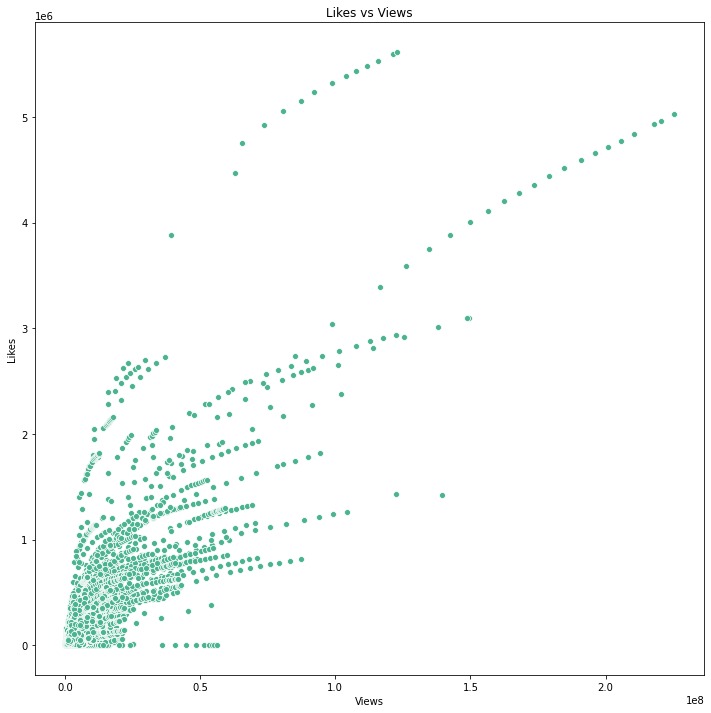

In [0]:
#Scatter plot of likes as views increase
plt.figure(figsize=(12,12))
fig = sns.scatterplot(x=youtubeDF["views"], y=youtubeDF["likes"], color="#4CB391", edgecolors="#000000", linewidths=0.5)
fig.set(xlabel= 'Views', ylabel= 'Likes', title = 'Likes vs Views');

Observations - 

> Initially likes increase proportionally, but once the views pass a limit, then the rate of increase decreases.

> Most videos can pass 0.2 (e^10) views and 1 (e^8) likes.

> The graph follows an equation, likes = a*√(views) where a in influenced by the category and other characteristics







In [0]:
#Let's compare the ratio of likes/views as views increase
youtubeDF['ratio'] = youtubeDF['likes'] / youtubeDF['views']

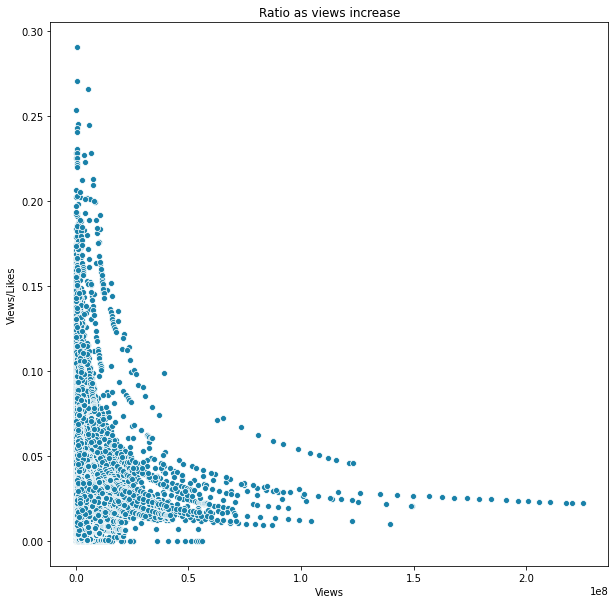

In [0]:
#Let's see a scatter plot of the ratio and views
plt.figure(figsize=(10,10))
fig = sns.scatterplot(x=youtubeDF["views"], y=youtubeDF["ratio"], color = '#1981A9', edgecolors="#000000", linewidths=0.5)
fig.set(xlabel= 'Views', ylabel= 'Views/Likes', title = 'Ratio as views increase');

One explaination for this observation can be- 

> Less veiwed videos are watched by supporters/binge watchers, who have a tendency to like.

> More viewed data is also shown to people inactive on youtube, who have less tendency to give a like. Hence Like/View ratio should decrease as the views increases.

## 2. Which category has the most number of trending videos? (IN vs US)

In [0]:
#Let's groupby category for US
usdf = (youtubeDF
       .groupby(by = ['category'])
       .count()[['video_id']]
       .reset_index()
       .sort_values(by = ['video_id'], ascending = False))
usdf.head()

,category,video_id
3,Entertainment,9964
7,Music,6472
6,Howto & Style,4146
1,Comedy,3457
10,People & Blogs,3210


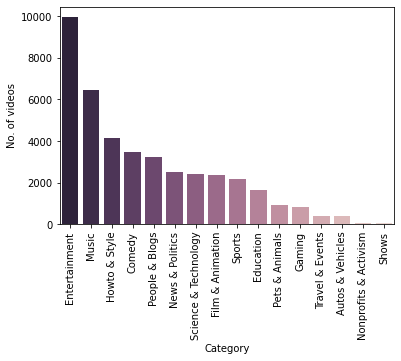

In [0]:
# Bar chart of category vs number of videos for US
fig, ax = plt.subplots()
sns.barplot(x="category", y="video_id", data=usdf, 
                palette=sns.cubehelix_palette(n_colors=16, reverse=True), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel="Category", ylabel="No. of videos");

In [0]:
#Let's load the India Data set to compare it with
indiaDF = pd.read_csv('/content/drive/Shared drives/Python Project/youtube-new/INvideos.csv')

In [0]:
#Adding category as genre
with open("/content/drive/Shared drives/Python Project/youtube-new/IN_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
indiaDF['category'] = indiaDF['category_id'].map(cat_dict)

In [0]:
indf = (indiaDF
       .groupby(by = ['category'])
       .count()[['video_id']]
       .reset_index()
       .sort_values(by = ['video_id'], ascending = False))
indf.head()

,category,video_id
3,Entertainment,16712
9,News & Politics,5241
8,Music,3858
1,Comedy,3429
10,People & Blogs,2624


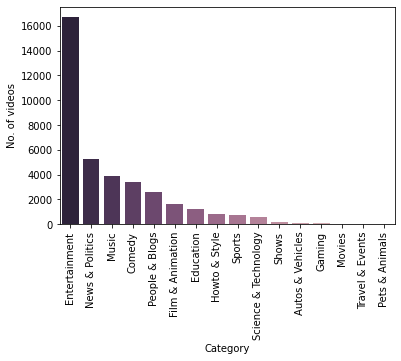

In [0]:
# Bar chart of category vs number of videos for IN
fig, ax = plt.subplots()
sns.barplot(x="category", y="video_id", data=indf, 
                palette=sns.cubehelix_palette(n_colors=16, reverse=True), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel="Category", ylabel="No. of videos");

### We can see that entertainment is the most trending category in both the countries, but in US we can see that the second most trending category in India, that might be due to the fact that it is a very diverse country, culturally and politically active.

## 3. For videos which are trending, what were the common words?

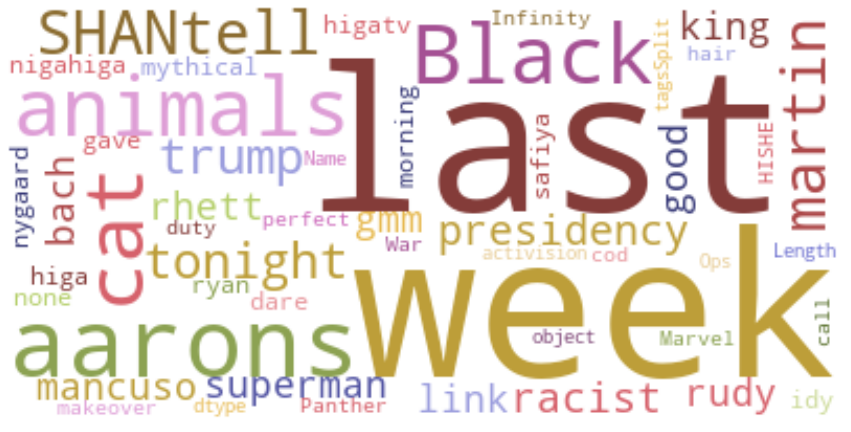

In [0]:
# Wordcloud for tags used in US videos
wordcloud = (WordCloud(background_color = 'white', collocations= False 
                      , colormap="tab20b" ).
                      generate(str(youtubeDF['tagsSplit'])))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

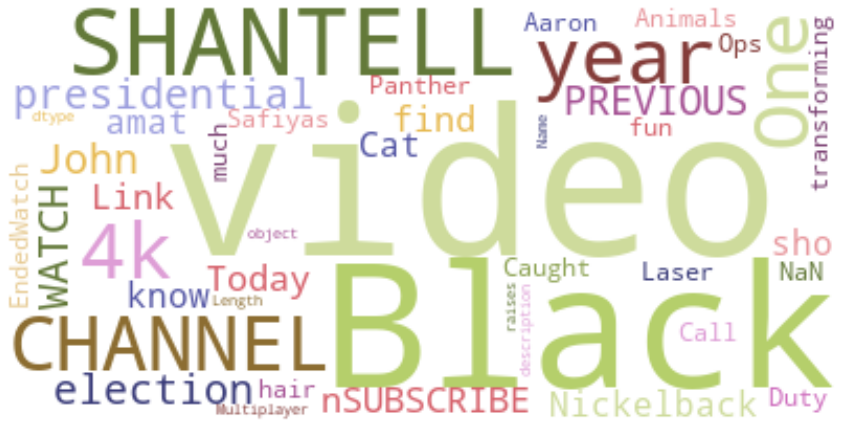

In [0]:
# Wordcloud for description used in US videos 
wc = (WordCloud(background_color= 'white', collocations= False, 
                      colormap="tab20b")
                      .generate(str(youtubeDF['description'])))
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

The 

In [0]:
#Let's look at the title in a different way 
titleWords = list(youtubeDF["title"].apply(lambda x: x.split()))
titleWords = [x for y in titleWords for x in y]
Counter(titleWords).most_common(25)

[('-', 11452),
 ('|', 10663),
 ('The', 5762),
 ('the', 3610),
 ('a', 2566),
 ('to', 2343),
 ('of', 2338),
 ('in', 2176),
 ('A', 2122),
 ('&', 2024),
 ('I', 1940),
 ('and', 1917),
 ('Video)', 1901),
 ('Trailer', 1868),
 ('How', 1661),
 ('with', 1655),
 ('2018', 1613),
 ('(Official', 1594),
 ('Official', 1554),
 ('on', 1552),
 ('To', 1397),
 ('You', 1254),
 ('My', 1080),
 ('for', 1020),
 ('ft.', 1017)]

(-0.5, 1199.5, 499.5, -0.5)

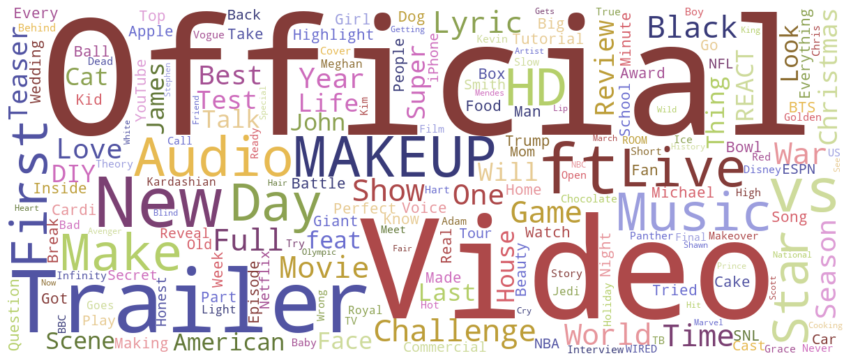

In [0]:
wc = (WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b")
      .generate(" ".join(titleWords)))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

## 4. Looking at the distribution of video attributes (Comments, likes, dislikes, length of video.)

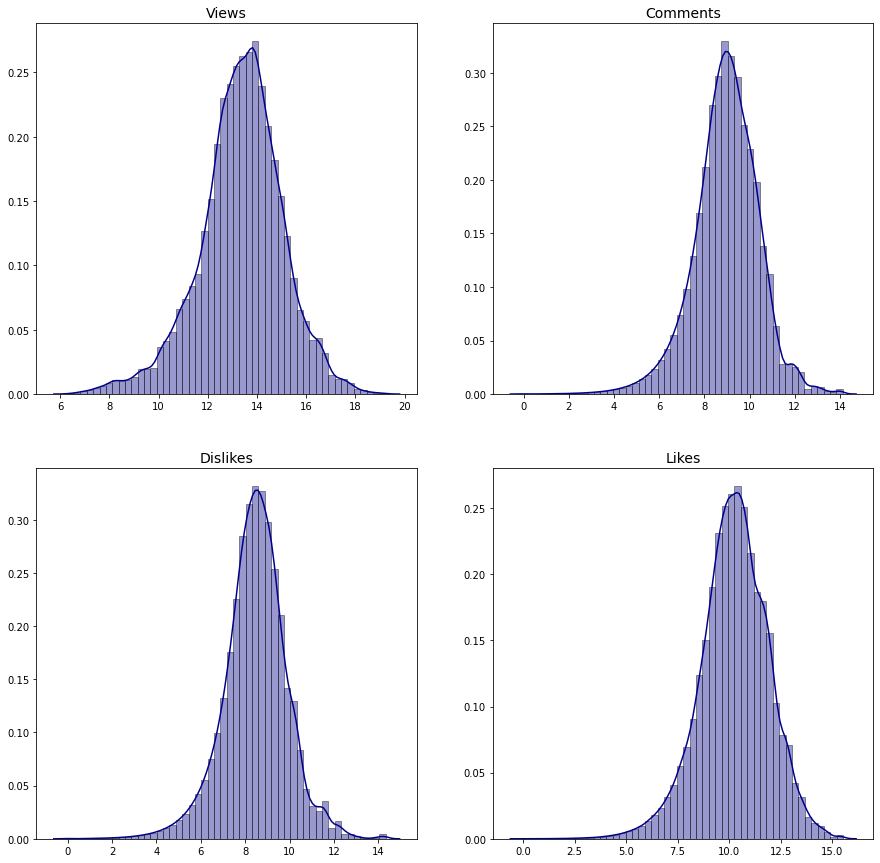

In [0]:
total_videos = len(youtubeDF)

plt.figure(figsize = (15,15))

#US views
plt.subplot(221)
views_ser = youtubeDF['views'].map(np.log)
v = sns.distplot(views_ser.unique(), norm_hist=True, kde=True,
             bins = 50, color = 'darkblue',hist_kws={'edgecolor':'black'})
v.set_title("Views", fontsize=14)

# US Comments 
plt.subplot(222)
youtubeDF['comment_count'].map(lambda value: np.log(value) if value != 0 else value).describe()
comment_ser = youtubeDF['comment_count'].map(lambda value: np.log(value) if value != 0 else value)
c = sns.distplot(comment_ser.unique(), norm_hist=True, kde=True,
             bins = 50, color = 'darkblue',hist_kws={'edgecolor':'black'})
c.set_title('Comments', fontsize = 14)

#US Disikes
plt.subplot(223)
dislikes_ser = youtubeDF['dislikes'].map(lambda value: np.log(value) if value != 0 else value)
d = sns.distplot(dislikes_ser.unique(), norm_hist=True, kde=True,
             bins = 50, color = 'darkblue',hist_kws={'edgecolor':'black'})
d.set_title('Dislikes', fontsize = 14)

#US likes
plt.subplot(224)
likes_ser = youtubeDF['likes'].map(lambda value: np.log(value) if value != 0 else value)
likes = sns.distplot(likes_ser.unique(), norm_hist=True, kde=True,
             bins = 50, color = 'darkblue',hist_kws={'edgecolor':'black'})
likes.set_title('Likes', fontsize = 14);

They closely resemble a normal distribution.

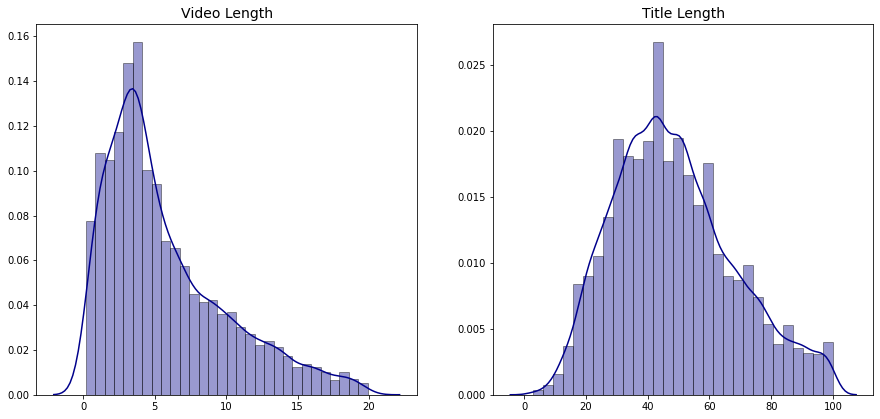

In [0]:
#Length of the video and length of the title

plt.figure(figsize = (15,15))
#US video lengths
plt.subplot(221)
lengths = pd.read_csv('/content/drive/Shared drives/Python Project/youtube-new/videoLengths.csv')
lengthFiltered = lengths[(lengths['length'] > 0) & (lengths['length'] < 1200)]
le = sns.distplot(lengthFiltered['length']/60, norm_hist=True, kde=True,
             bins = int(180/6), color = 'darkblue', hist_kws={'edgecolor':'black'})
le.set_title('Video Length', fontsize = 14);
le.set(xlabel = '');

#US title lengths
plt.subplot(222)
youtubeDF["title_length"] = youtubeDF["title"].apply(lambda x: len(x))
e = sns.distplot(youtubeDF['title_length'], norm_hist=True, kde=True,
             bins = int(180/6), color = 'darkblue', hist_kws={'edgecolor':'black'})
e.set_title('Title Length', fontsize = 14);
e.set(xlabel='');

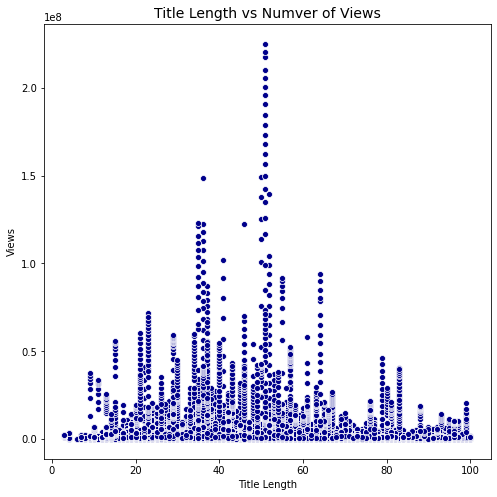

In [0]:
#Let's look more into the length of the title with the number of views
plt.figure(figsize=(8,8))
youtubeDF["title_length"] = youtubeDF["title"].apply(lambda x: len(x))
l = sns.scatterplot(x = youtubeDF['title_length'], y = youtubeDF['views'], color = 'darkblue')
l.set(xlabel = 'Title Length', ylabel = 'Views');
l.set_title('Title Length vs Numver of Views', fontsize = 14);

We can see that there is no relation with the length of the title vs the number of views.
However videos with more than 100,000,000 views have a title length of around 50 consistently.

## 5. Publish time relating to trending status?

In [0]:
#Avg number of days a video trends for, per genre.
no_of_days_trending=pd.DataFrame(youtubeDF.loc[:,('category','video_id')].groupby(by=['category','video_id'])['video_id'].agg(days_count='count'))
average_trending_days_category = pd.DataFrame(no_of_days_trending.reset_index().groupby(by=['category'])['days_count'].agg('mean')).reset_index().sort_values(by='days_count', ascending=False).style.hide_index()
average_trending_days_category

category,days_count
Shows,14.250000
Music,8.079900
Gaming,7.932039
Film & Animation,7.305296
Howto & Style,6.968067
Travel & Events,6.700000
Education,6.597610
Pets & Animals,6.524823
People & Blogs,6.445783
Comedy,6.319927


We can see that Shows tend to trend for a longer time, because they are genrally longer and so that people spend more time to watch it.

In [0]:
hourDF = (youtubeDF
          .groupby(by = ['publish_hour'])
          .count()['video_id']
          .reset_index()
          .sort_values(by = ['video_id'], ascending = False)
).reset_index(drop = True)

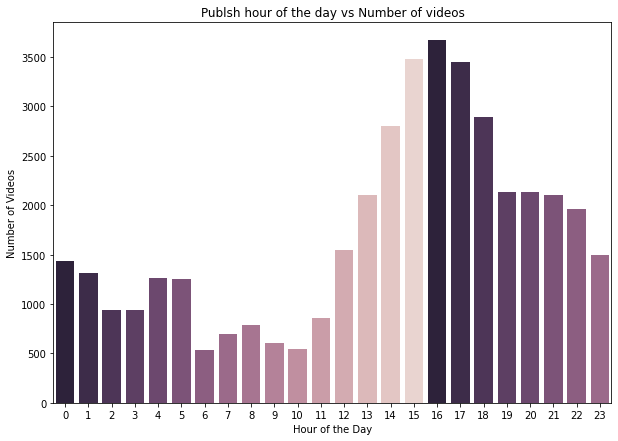

In [0]:
plt.figure(figsize=(10,7))
h = sns.barplot(hourDF['publish_hour'], hourDF['video_id'], 
           palette=sns.cubehelix_palette(n_colors=16, reverse=True))
h.set_title('Publsh hour of the day vs Number of videos');
h.set(xlabel='Hour of the Day', ylabel= 'Number of Videos');

We can see that videos that are not published during office hours quickly make it to the trending section.

# Conclusions
---
1. There is a strong positive correlation between the number of views and the number of likes of trending videos: As one of them increases, the other increases, and vice versa.
2. Trending videos that have 100,000,000 views and more have title length between 33 and 55 characters approximately.
3. The word 'Official', 'Video', 'Trailer', 'How', and '2018' are the 
4. Region does have an effect on the trending status, the genre which appeals to more people in a region has a higher probability of trending.
5. Videos uploaded during off office hours, get more attention and hence have a higher probability to trend.
